### Loading Pacakge and configuration

In [1]:
import pandas as pd
import numpy as np
import time 
import datetime

from hdbcli import dbapi
import multiprocessing

In [2]:
pd.set_option('display.max_rows',100,'display.max_columns',100)

Setting workers

In [11]:
def DB_Connection(server, schema = 'default') :
    if server == 'opr' : ## 운영
        conn=dbapi.connect('10.253.79.141',30015,'CDS_ANY','Cds12345') 
    elif server == 'sandbox' : ## sandbox 
        conn=dbapi.connect('10.253.79.145',30015,'CDS_DEV1','Emartcds1!') 
    elif server == 'dev' and schema == 'DW' : ## 개발 DW 
        conn=dbapi.connect('10.253.79.146',30015,'CDS_DW','Sap12345')
    elif server == 'dev' and schema == 'AMT' : ## 개발 AMT
        conn=dbapi.connect('10.253.79.146',30015,'CDS_AMT','Sap12345')
    else :
        print('선택된 DB명을 확인해주세요.')
    
    return conn


def worker(a) :
    key_list = list(flt_condition)
    a = "'"+a+"'" # print(a)

    if flt_type == 'default' :
        query_main = f""" SELECT * FROM  {db_name} WHERE {key_variable} = {a} """
    
    elif flt_type == 'cat' :
        query_main = f""" 
        SELECT * FROM {db_name} 
        WHERE ({key_list[0]} = {flt_condition[key_list[0]]} and {key_list[1]} = {flt_condition[key_list[1]]})     
                AND {key_variable} = {a} """
    
    else : 
        flt = ["'" + x + "'" for x in list(flt_condition.values())]
        query_main = f"""
        SELECT * FROM {db_name} 
        WHERE ({flt_var} >= {flt[0]} and {flt_var} <= {flt[1]})     
                AND {key_variable} = {a} """
        
    conn = DB_Connection(server, schema)
    result = pd.read_sql(query_main, conn)
    conn.close()
    
    return result


def Datachunk_range(key_variable) :
    key_list = list(flt_condition)
    print(key_list)
    print(flt_condition[key_list[0]], flt_condition[key_list[1]])
    
    if flt_type == 'default' :
        query_arg = f" SELECT distinct {key_variable} FROM {db_name} "
    
    elif flt_type == 'cat' :
        query_arg = f""" 
        SELECT distinct {key_variable} FROM {db_name} 
        WHERE ({key_list[0]} = {flt_condition[key_list[0]]} and {key_list[1]} = {flt_condition[key_list[1]]}) 
        """
    else : 
        flt = ["'" + x + "'" for x in list(flt_condition.values())]
        query_arg = f""" 
        SELECT distinct {key_variable} FROM {db_name} 
        WHERE ({flt_var} >= {flt[0]} and {flt_var} <= {flt[1]})     
        """
    conn = DB_Connection(server, schema)
    arg_list = pd.read_sql(query_arg, conn)
    
    arg_list = arg_list.iloc[:,0].values.tolist()
    arg_list_flt = [arg_list[i] for i in range(len(arg_list)) if arg_list[i] != None] ## None 타입 제외
    
    conn.close()
    
    return arg_list_flt


def multiprocesser() : 
    arg_list = Datachunk_range(key_variable = key)
    print(arg_list)
    
    p = multiprocessing.Pool(processes = n_core)
    data = p.map(worker, arg_list) 
    p.close()
    result = pd.concat(data)
    
    return result    

Data Loading

In [12]:
## --------------------------------------------------
## 상품 마스터 가져오기
## --------------------------------------------------
## multiprocessing 준비
db_name = 'CDS_DW.TB_DW_PRDT_DCODE_CD' ## target DB 
server = 'opr' # server_category = 'sandbox' 
schema = 'default' # schema
n_core = 10

## multiprocessing 을 위한 arg list
key_variable = 'PRDT_CAT_CD'

## filter variable
flt_type = 'cat'
flt_condition = {'AFLCO_CD':'001','BIZTP_CD':'10'}

prdt_mst = multiprocesser() # multiprocessing.cpu_count()


['AFLCO_CD', 'BIZTP_CD']
001 10
['67', '62', '99', '22', '11', '14', '43', '13', '15', '21', '98', '24', '41', '56', '33', '44', '34', '66', '53', '47', '65', '61', '97', '49', '51', '52', '54', '55', '69']


In [13]:
## --------------------------------------------------
## 데이터 가져오기 
## --------------------------------------------------
## multiprocessing 준비
db_name = 'CDS_AMT.TB_AMT_RECMD_TMPR' ## target DB 
server = 'dev' # server_category = 'sandbox' 
schema = 'AMT' # schema
n_core = 10

## data chuck arg 를 위한 기준 변수
key_variable = 'PRDT_CAT_CD'

## filter date
flt_type = 'date'
flt_var ='ANL_DT'
flt_condition = {'from':'2020-10-21','to':'2020-10-21'} ## from , ## to

result = multiprocesser() # multiprocessing.cpu_count()


['from', 'to']
2020-10-21 2020-10-21
['11', '13', '14', '15', '21', '22', '24', '33', '34', '41', '43', '44', '47', '49', '51', '52', '53', '54', '55', '56', '61', '62', '65', '66', '99']


In [14]:
bf = len(result)
result = result.drop_duplicates()
af = len(result)
print(bf, "->",af)

18440125 -> 18440125


### Pre-processing

In [15]:
ratings = result[['CUST_ID','PRDT_DCODE_CD','DT_CNT','SUM_QTY']]

In [16]:
display(ratings.head())
display(ratings.info())

,CUST_ID,PRDT_DCODE_CD,DT_CNT,SUM_QTY
0,C69402503,5815,1,1.0
1,C69402503,5107,1,1.0
2,C69402503,0115,1,1.0
3,C69402503,5089,1,1.0
4,C71670223,5026,1,1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18440125 entries, 0 to 219139
Data columns (total 4 columns):
CUST_ID          object
PRDT_DCODE_CD    object
DT_CNT           int64
SUM_QTY          float64
dtypes: float64(1), int64(1), object(2)
memory usage: 703.4+ MB


None

#### tf - idf matrix 생성
 - tfidf vectorizer 는 토큰화가 되어 있지 않은 텍스트 데이터를 입력으로 사용함
 - 따라서 토큰화된 데이터를 역 토큰화 (Detokenization) 해주는 작업이 필요함
 - 본 데이터는 역 토큰화 없이 바로 수식으로 tf-idf 메트릭스로 변환

In [17]:
## 상품 리스트 사전
prdt_cd = list(ratings['PRDT_DCODE_CD'].unique())
prdt_cd.sort()

## 전체 DCODE MASTER 에서 PRCD_CD 에 미포함된 DCODE_CD 추출
prdt_map = prdt_mst[['PRDT_DCODE_CD','PRDT_DCODE_NM']]
prdt_cd_all = prdt_mst['PRDT_DCODE_CD'].unique().tolist()

## document length
N = len(ratings['CUST_ID'].unique())
print(N)

353987


In [18]:
def tf_idf_matrix_all(df, prdt_cd_all) : 
    ## TF Matrix 변환 
    tf = pd.pivot_table(df, values = 'DT_CNT', index = 'CUST_ID', columns = 'PRDT_DCODE_CD')
    tf = tf.fillna(0)
    
    ## IDF Matrix 계산 
    idf = df.groupby(['PRDT_DCODE_CD']).sum()['DT_CNT']
    idf = np.log(N/(idf + 1))
    
    # TF-IDF Matrix 계산
    tfidf = tf * idf
    
    # df 에 미포함된 DCODE_CD 칼럼화
    prdt_cd_current = tf.columns.tolist()
    prdt_cd_new = set(prdt_cd_all) - set(prdt_cd_current)
    
    tfidf_all = tfidf.reindex(columns = [*prdt_cd_current, *list(prdt_cd_new)], fill_value = float(0) )
    tfidf_all = tfidf_all[sorted(prdt_cd_all)] ## rearrange the column names    
    
    print(tf.shape, idf.shape, tfidf.shape, "-->",tfidf_all.shape)
    display(tfidf_all.head())
    
    return tfidf_all
    

In [24]:
tfidf = tf_idf_matrix_all(ratings , prdt_cd_all)
X = np.array(tfidf)
X.shape

(353987, 2592) (2592,) (353987, 2592) --> (353987, 3825)


PRDT_DCODE_CD,0001,0002,0003,0004,0009,0010,0011,0012,0013,0014,0015,0016,0017,0018,0019,0020,0022,0023,0024,0025,0026,0027,0029,0031,0032,0035,0037,0038,0039,0040,0041,0042,0044,0045,0046,0048,0049,0050,0051,0052,0053,0054,0055,0056,0057,0059,0060,0061,0062,0063,...,9923,9924,9925,9926,9927,9928,9929,9930,9931,9932,9933,9934,9935,9936,9937,9940,9948,9950,9954,9956,9957,9958,9960,9961,9962,9963,9964,9965,9966,9967,9969,9970,9971,9972,9973,9974,9975,9976,9978,9981,9982,9983,9984,9985,9986,9987,9990,9997,9998,9999
CUST_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C10000133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.432943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
C10000183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
C10000254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
C10000313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
C10000320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.177882,0.0


(353987, 3825)

#### Truncated SVD Tuning 
-  https://ariz1623.tistory.com/219

적정 component 개수 확인

In [20]:
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import time

In [462]:
n_comp = [4,10,20,30,40,50,100,150,200,300,400,500,600,700,800,900,1000,1500,2000,2500]

var_explained  = []
for i in n_comp : 
    svd_model = TruncatedSVD(n_components = i, algorithm = 'randomized', n_iter = 100, random_state = 1234)
    svd_model.fit(X)
    var_explained.append(svd_model.explained_variance_ratio_.sum())
    print(f"Number of components = {i} and explained variance = {svd_model.explained_variance_ratio_.sum()}")


Number of components = 4 and explained variance = 0.042311662692287394
Number of components = 10 and explained variance = 0.07171610434649758
Number of components = 20 and explained variance = 0.10587628079255633
Number of components = 30 and explained variance = 0.13284226093527599
Number of components = 40 and explained variance = 0.1561371717284956
Number of components = 50 and explained variance = 0.177105333753792
Number of components = 100 and explained variance = 0.26261623405995144
Number of components = 150 and explained variance = 0.3304377464185413
Number of components = 200 and explained variance = 0.3893030415738942
Number of components = 300 and explained variance = 0.4867581591146163
Number of components = 400 and explained variance = 0.5657522803946423
Number of components = 500 and explained variance = 0.6323994490240394
Number of components = 600 and explained variance = 0.6891921967490098
Number of components = 700 and explained variance = 0.7380553975678716
Number o

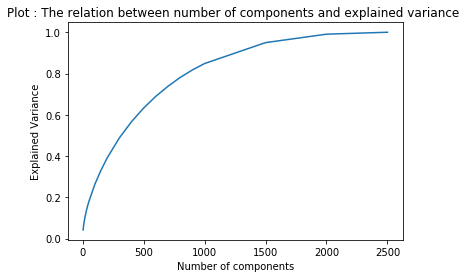

In [463]:
plt.plot(n_comp[:len(var_explained)], var_explained)
plt.xlabel('Number of components')
plt.ylabel('Explained Variance')
plt.title('Plot : The relation between number of components and explained variance ')
plt.show() 

## 계산 결과를 보면,,
## 토픽 개수가 소수일 경우 분산 설명력이 매우 떨어짐.

## 20.10.26. updates :
## component 기준으로 n = 1000 개 이상 되어야 분산 설명력이 82% 가량 됨
## 따라서 n_comp = 1000 으로 진행하겠음.

## 20.10.30 updates : 
## components = 1000 일 때, 유사도 계산 속도가 급격하게 저하.
## 60% 정도 되는 n= 500 으로 축소하여 진행하기로 변경 

 ### 고객 유사도 계산
 - 중간 계산 로직은 다음을 검토할 수 있음  
 
 - tf-idf matrix 혹은 U matrix 를 사용하여 코사인 유사도를 계산    
   즉, knn 으로 유사한 고객 X 명 (i.e., 100명을 뽑던지...)      
      --->  sorting 하여 X 명 추출
 
 - 혹은 클러스터링으로 묶어서 --> 집단을 추출
 
 --> 그 사람들이 구매한 상품들의 비중을 집계하여 뿌려줌. 

 --> 뿌려주는 형태는 fastFM 결과와 동일

#### Truncated SVD 수행

In [21]:
svd_model = TruncatedSVD(n_components = 500, algorithm = 'randomized', n_iter = 100, random_state = 1234)
svd_model.fit(X)


TruncatedSVD(algorithm='randomized', n_components=500, n_iter=100,
             random_state=1234, tol=0.0)

In [22]:
## 각 행렬의 Matrix shape 확인
U = svd_model.transform(X)
S = svd_model.singular_values_
VT = svd_model.components_
print(U.shape, S.shape, VT.shape)

## 각 토픽의 분산 설명력
var_exp = svd_model.explained_variance_ratio_
print("explained variance ratio : ", svd_model.explained_variance_ratio_.sum())
# print(var_exp)


(353987, 500) (500,) (500, 3825)
explained variance ratio :  0.5914663974046472


#### 코사인 유사도 계산

##### 코호트 별  장바구니 합계 비중 도출
Try 1. 처음에는 모든 고객 간 코사인 유사도를 계산하려 시도했으나 Memory Error 발생       
 
Try 2. 코호트 별 코사인 유사도 계산     
    1. 따라서 PLM (People Like Me) 의 취지에 맞게끔, 연령대(AGRDE) X 성별(GNDR) 로 코호트 집단을 나누고,      
       코호트 집단 별로 코사인 유사도를 계산.
       
       1.1. 연령X성별 별로 집단 카운트 후, 100명 미만인 코호트는 제외      
            (10대 제외 , 성별코드가 3 인 집단 제외)
       
    2. 코사인 유사도 계산 결과를 토대로 거리가 가장 가까운 100명 추출 
            (KNN = 100, 본인 제외)
            
    3. 고객과 유사한 100 명이 구매한 상품을 집계하여 장바구니 합계 비중 산출 + Sorting  

In [26]:

def cohort_cos_similarity(var, i) : 
    L = cus_demo[(cus_demo[var[0]] == i[0]) & (cus_demo[var[1]] == i[1])].CUST_ID
    U_flt = U[indices[L.values]] # index
    cos_sim = cosine_similarity(U_flt, U_flt)
    return L, cos_sim

def knn(a,n=100) : 
    return [L.values[i] for i in a.argsort()[-n-1:-1]]


In [27]:

def knn_prdt(a, df = ratings) : 
    df_agg = df[df['CUST_ID'].isin(a[1])].groupby('PRDT_DCODE_CD').sum().reset_index()
    df_agg['DT_RT'] = np.round(df_agg.DT_CNT / df_agg.DT_CNT.sum(),5)
    df_agg = df_agg.sort_values(by= 'DT_RT', ascending = False)
    df_agg['CUST_ID'] = a[0]
    # print(a[0])
    
    return df_agg

def cosine_multiprocesser2() : 
    p = multiprocessing.Pool(processes = n_core)
    data = p.map(knn_prdt, zip(L,KNN_list)) # cus_list 
    p.close()
    result = pd.concat(data)
    
    return result    


In [25]:
##고객을 조회하면 index 리턴
cus_list = tfidf.index.unique().tolist()
indices = pd.Series( range(len(cus_list)), index = cus_list ).drop_duplicates()

# test_list = cus_list[:1000]

In [28]:
cohort_cond = ['GNDR_CD','AGRDE'] 

cus_demo = result[['CUST_ID','GNDR_CD','AGRDE','SHOP_DNA_SGMNT','CUST_GRADE_CD']].drop_duplicates()
demo_agg = cus_demo.groupby(cohort_cond).count().reset_index()
demo_agg_flt = demo_agg[demo_agg['CUST_ID'] > 100] # 고객수가 100 미만인 cohort 는 제외


In [ ]:
n_core = np.round(multiprocessing.cpu_count() * 0.6 ,0).astype('int')
print(n_core)

plm_res = pd.DataFrame()
for k in demo_agg_flt[cohort_cond].values :

    start_time = time.time()
    
    L, cos_sim = cohort_cos_similarity(var = cohort_cond, i=k)
    KNN_list = np.apply_along_axis(knn, 1, cos_sim)
    print("[",cohort_cond[0]," : ",k[0], "/", cohort_cond[1]," : ",k[1],"/",len(L)," ]")
    
    plm_res_tmp = cosine_multiprocesser2()
    plm_res = pd.concat([plm_res, plm_res_tmp])
    
    end_time = time.time()
    print("Time elapsed : ", round((end_time - start_time) / 60, 2), "min")
    

In [30]:
plm_res.to_csv("plm_res_lsa_all_1030.csv")

##### 원본 데이터와 결합하여 비교

In [31]:
sample_plm = plm_res[plm_res.CUST_ID == 'C21582796']
sample_plm = sample_plm.rename(columns = {'DT_CNT':'PLM_DT_CNT','SUM_QTY':'PLM_SUM_QTY','DT_RT':'PLM_DT_RATE'})

sample_raw = result[result.CUST_ID == 'C21582796']
sample_raw = sample_raw[['CUST_ID','PRDT_CAT_CD','PRDT_DCODE_CD','ANL_DT','DT_CNT','SUM_QTY',
                         'DT_RATE','GNDR_CD','AGRDE','SHOP_DNA_SGMNT','CUST_GRADE_CD']]

sample_merge = pd.merge(sample_raw, sample_plm, how = 'outer', on = ['CUST_ID','PRDT_DCODE_CD'])

In [32]:
print(sample_merge.columns)
with pd.option_context('display.max_rows', 1000, 'display.max_columns',100) :
    display(sample_merge)


Index(['CUST_ID', 'PRDT_CAT_CD', 'PRDT_DCODE_CD', 'ANL_DT', 'DT_CNT',
       'SUM_QTY', 'DT_RATE', 'GNDR_CD', 'AGRDE', 'SHOP_DNA_SGMNT',
       'CUST_GRADE_CD', 'PLM_DT_CNT', 'PLM_SUM_QTY', 'PLM_DT_RATE'],
      dtype='object')


,CUST_ID,PRDT_CAT_CD,PRDT_DCODE_CD,ANL_DT,DT_CNT,SUM_QTY,DT_RATE,GNDR_CD,AGRDE,SHOP_DNA_SGMNT,CUST_GRADE_CD,PLM_DT_CNT,PLM_SUM_QTY,PLM_DT_RATE
0,C21582796,11,0175,2020-10-21,1.0,1.00,0.038461,1,20,01,2,10.0,10.00,0.00152
1,C21582796,11,1057,2020-10-21,2.0,2.00,0.076923,1,20,01,2,1.0,1.00,0.00015
2,C21582796,11,5055,2020-10-21,2.0,2.00,0.076923,1,20,01,2,26.0,28.00,0.00394
3,C21582796,11,5001,2020-10-21,3.0,3.00,0.115384,1,20,01,2,22.0,25.00,0.00333
4,C21582796,13,5091,2020-10-21,1.0,1.00,0.038461,1,20,01,2,18.0,83.30,0.00273
5,C21582796,13,5114,2020-10-21,1.0,1.00,0.038461,1,20,01,2,5.0,4.50,0.00076
6,C21582796,13,5122,2020-10-21,2.0,2.00,0.076923,1,20,01,2,23.0,23.00,0.00348
7,C21582796,13,5786,2020-10-21,7.0,7.00,0.269230,1,20,01,2,126.0,130.00,0.01909
8,C21582796,13,5112,2020-10-21,3.0,3.00,0.115384,1,20,01,2,28.0,28.00,0.00424
9,C21582796,13,5131,2020-10-21,1.0,1.00,0.038461,1,20,01,2,27.0,28.00,0.00409


In [33]:
sample_merge.to_csv('plm_res_sample_201030.csv')

##### 토픽내 상품 구성 비교

In [35]:
items = tfidf.columns.tolist()
items = pd.DataFrame(items, columns = ['PRDT_DCODE_CD'])
item_df = pd.merge(items, prdt_mst[['PRDT_DCODE_CD','PRDT_DCODE_NM']], how = 'left', on = 'PRDT_DCODE_CD')
# display(item_df)
item_nm = item_df['PRDT_DCODE_NM'].tolist()

In [36]:
def get_topics(components, feature_names, n) :
    for idx, topic in enumerate(components) :
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(3)) for i in topic.argsort()[: -n - 1 :-1]])
        

In [37]:
get_topics(VT, item_nm, n=5)

Topic 1: [('APC애호박', 0.077), ('국산콩나물', 0.076), ('APC대파', 0.076), ('깻잎', 0.075), ('다다기오이', 0.075)]
Topic 2: [('올)엽채소', 0.123), ('브로콜리', 0.117), ('가지', 0.115), ('올)과채소', 0.105), ('APC파프리카', 0.103)]
Topic 3: [('올)우유', 0.235), ('국산영유아간편식', 0.209), ('올)요쿠르트', 0.189), ('올)음료', 0.138), ('어린이음료', 0.135)]
Topic 4: [('병/페트맥주', 0.65), ('올)우유', 0.229), ('올)요쿠르트', 0.206), ('탁주', 0.178), ('노브랜드 우유', 0.163)]
Topic 5: [('병/페트맥주', 0.523), ('탁주', 0.122), ('소주', 0.067), ('캔맥주', 0.061), ('반려묘습식사료', 0.051)]
Topic 6: [('반려묘습식사료', 0.314), ('반려묘간식', 0.258), ('레드와인', 0.157), ('허브', 0.134), ('반려견맛있는간식', 0.121)]
Topic 7: [('반려묘습식사료', 0.331), ('반려묘간식', 0.256), ('노브랜드 우유', 0.248), ('올)우유', 0.164), ('올)요쿠르트', 0.142)]
Topic 8: [('반려묘습식사료', 0.464), ('반려묘간식', 0.381), ('병/페트맥주', 0.137), ('반려견맛있는간식', 0.119), ('국산영유아간편식', 0.109)]
Topic 9: [('노브랜드 우유', 0.239), ('냉장커피', 0.202), ('병/페트맥주', 0.189), ('티음료', 0.168), ('생수', 0.15)]
Topic 10: [('냉장커피', 0.286), ('반려묘습식사료', 0.282), ('반려묘간식', 0.217), ('상온커피', 0.109), ('티음료', 0.102)]

#### 신규 데이터 적용
- 테스트 형식으로 일부 데이터만 가지고 진행

In [38]:
## 2020-10-22 데이터 로딩

## --------------------------------------------------
## 데이터 가져오기 
## --------------------------------------------------
## multiprocessing 준비
db_name = 'CDS_AMT.TB_AMT_RECMD_TMPR' ## target DB 
server = 'dev' # server_category = 'sandbox' 
schema = 'AMT' # schema
n_core = 10

## data chuck arg 를 위한 기준 변수
key = 'PRDT_CAT_CD'

## filter date
flt_type = 'date'
flt_var ='ANL_DT'
flt_condition = {'from':'2020-10-22','to':'2020-10-22'} ## from , ## to

test_dataset = multiprocesser() # multiprocessing.cpu_count()

['from', 'to']
2020-10-22 2020-10-22
['11', '13', '14', '15', '21', '22', '24', '33', '34', '41', '43', '44', '47', '49', '51', '52', '53', '54', '55', '56', '61', '62', '65', '66', '69', '99']


In [39]:
cus_list_test = test_dataset['CUST_ID'].unique().tolist()
cus_list_train = ratings['CUST_ID'].unique().tolist()
cus_list_new = set(cus_list_test) - set(cus_list_train)

In [40]:
test_df = test_dataset[test_dataset['CUST_ID'].isin(list(cus_list_new))]
test_df_ratings = test_df[['CUST_ID','PRDT_DCODE_CD','DT_CNT','SUM_QTY']]
test_df_tfidf = tf_idf_matrix_all(test_df_ratings, prdt_cd_all)

X_test = np.array(test_df_tfidf)
X_test.shape

(329489, 2585) (2585,) (329489, 2585) --> (329489, 3825)


PRDT_DCODE_CD,0001,0002,0003,0004,0009,0010,0011,0012,0013,0014,0015,0016,0017,0018,0019,0020,0022,0023,0024,0025,0026,0027,0029,0031,0032,0035,0037,0038,0039,0040,0041,0042,0044,0045,0046,0048,0049,0050,0051,0052,0053,0054,0055,0056,0057,0059,0060,0061,0062,0063,...,9923,9924,9925,9926,9927,9928,9929,9930,9931,9932,9933,9934,9935,9936,9937,9940,9948,9950,9954,9956,9957,9958,9960,9961,9962,9963,9964,9965,9966,9967,9969,9970,9971,9972,9973,9974,9975,9976,9978,9981,9982,9983,9984,9985,9986,9987,9990,9997,9998,9999
CUST_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C10000138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.77143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.912546,0.0
C10000479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
C10000499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.825092,0.0
C10000729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
C10000737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


(329489, 3825)

In [41]:
U_test = svd_model.fit_transform(X_test)

In [42]:
U_test.shape

(329489, 500)